# Utilities

> Random utilities. Copied entirely from FastAI so I can avoid implementing the annoying stuff. Not original work.

In [1]:
#| default_exp utils

In [2]:
# |export
import gc
import math
import sys
import traceback
from functools import partial
from itertools import zip_longest
from typing import Optional

import fastcore.all as fc
import matplotlib.pyplot as plt
import numpy as np
import requests
import torch
import torchvision.transforms.functional as T
from datasets import load_dataset
from glom import glom
from PIL import Image
from torch.utils.data import DataLoader

In [3]:
# |export
def clean_ipython_hist():
    # Code in this function mainly copied from IPython source
    if not "get_ipython" in globals():
        return
    ip = get_ipython()
    user_ns = ip.user_ns
    ip.displayhook.flush()
    pc = ip.displayhook.prompt_count + 1
    for n in range(1, pc):
        user_ns.pop("_i" + repr(n), None)
    user_ns.update(dict(_i="", _ii="", _iii=""))
    hm = ip.history_manager
    hm.input_hist_parsed[:] = [""] * pc
    hm.input_hist_raw[:] = [""] * pc
    hm._i = hm._ii = hm._iii = hm._i00 = ""

In [4]:
# |export
def clean_tb():
    # h/t Piotr Czapla
    if hasattr(sys, "last_traceback"):
        traceback.clear_frames(sys.last_traceback)
        delattr(sys, "last_traceback")
    if hasattr(sys, "last_type"):
        delattr(sys, "last_type")
    if hasattr(sys, "last_value"):
        delattr(sys, "last_value")

In [5]:
# |export
def clean_mem():
    clean_tb()
    clean_ipython_hist()
    gc.collect()
    torch.cuda.empty_cache()

In [6]:
# |export
@fc.delegates(plt.subplots, keep=True)
def subplots(
    nrows: int = 1,  # Number of rows in returned axes grid
    ncols: int = 1,  # Number of columns in returned axes grid
    figsize: tuple = None,  # Width, height in inches of the returned figure
    imsize: int = 3,  # Size (in inches) of images that will be displayed in the returned figure
    suptitle: str = None,  # Title to be set to returned figure
    **kwargs
):  # fig and axs
    "A figure and set of subplots to display images of `imsize` inches"
    if figsize is None:
        figsize = (ncols * imsize, nrows * imsize)
    fig, ax = plt.subplots(nrows, ncols, figsize=figsize, **kwargs)
    if suptitle is not None:
        fig.suptitle(suptitle)
    if nrows * ncols == 1:
        ax = np.array([ax])
    return fig, ax

In [7]:
# |export
@fc.delegates(plt.subplots, keep=True)
def subplots(
    nrows: int = 1,  # Number of rows in returned axes grid
    ncols: int = 1,  # Number of columns in returned axes grid
    figsize: tuple = None,  # Width, height in inches of the returned figure
    imsize: int = 3,  # Size (in inches) of images that will be displayed in the returned figure
    suptitle: str = None,  # Title to be set to returned figure
    **kwargs,
):  # fig and axs
    "A figure and set of subplots to display images of `imsize` inches"
    if figsize is None:
        figsize = (ncols * imsize, nrows * imsize)
    fig, ax = plt.subplots(nrows, ncols, figsize=figsize, **kwargs)
    if suptitle is not None:
        fig.suptitle(suptitle)
    if nrows * ncols == 1:
        ax = np.array([ax])
    return fig, ax


@fc.delegates(subplots)
def get_grid(
    n: int,  # Number of axes
    nrows: int = None,  # Number of rows, defaulting to `int(math.sqrt(n))`
    ncols: int = None,  # Number of columns, defaulting to `ceil(n/rows)`
    title: str = None,  # If passed, title set to the figure
    weight: str = "bold",  # Title font weight
    size: int = 14,  # Title font size
    **kwargs,
):  # fig and axs
    "Return a grid of `n` axes, `rows` by `cols`"
    if nrows:
        ncols = ncols or int(np.floor(n / nrows))
    elif ncols:
        nrows = nrows or int(np.ceil(n / ncols))
    else:
        nrows = int(math.sqrt(n))
        ncols = int(np.floor(n / nrows))
    fig, axs = subplots(nrows, ncols, **kwargs)
    for i in range(n, nrows * ncols):
        axs.flat[i].set_axis_off()
    if title is not None:
        fig.suptitle(title, weight=weight, size=size)
    return fig, axs


@fc.delegates(plt.Axes.imshow)
def show_image(im, ax=None, figsize=None, title=None, noframe=True, **kwargs):
    "Show a PIL or PyTorch image on `ax`."
    if fc.hasattrs(im, ("cpu", "permute", "detach")):
        im = im.detach().cpu()
        if len(im.shape) == 3 and im.shape[0] < 5:
            im = im.permute(1, 2, 0)
    elif not isinstance(im, np.ndarray):
        im = np.array(im)
    if im.shape[-1] == 1:
        im = im[..., 0]
    if ax is None:
        _, ax = plt.subplots(figsize=figsize)
    if im.shape[0] == 1:
        ax.imshow(im, cmap=plt.cm.gray, **kwargs)
    else:
        ax.imshow(im, **kwargs)
    if title is not None:
        ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    if noframe:
        ax.axis("off")
    return ax


@fc.delegates(subplots)
def show_images(
    ims: list,  # Images to show
    nrows: Optional[int] = None,  # Number of rows in grid
    ncols: Optional[int] = None,  # Number of columns in grid (auto-calculated if None)
    titles: Optional[list] = None,  # Optional list of titles for each image
    ax_kwargs=None,
    **kwargs,
):
    "Show all images `ims` as subplots with `rows` using `titles`"
    if ax_kwargs is None:
        ax_kwargs = {}
    axs = get_grid(len(ims), nrows, ncols, **kwargs)[1].flat
    for im, t, ax in zip_longest(ims, titles or [], axs):
        show_image(im, ax=ax, title=t, **ax_kwargs)

In [8]:
# |export
def glomf(spec):
    return partial(glom, spec=spec)

In [9]:
# |export
class Suppressor:
    """Stolen from: https://stackoverflow.com/questions/2828953/silence-the-stdout-of-a-function-in-python-without-trashing-sys-stdout-and-resto"""

    def __enter__(self):
        self.stdout = sys.stdout
        sys.stdout = self

    def __exit__(self, exception_type, value, traceback):
        sys.stdout = self.stdout
        if exception_type is not None:
            # Do normal exception handling
            raise Exception(f"Got exception: {exception_type} {value} {traceback}")

    def write(self, x):
        pass

    def flush(self):
        pass

In [13]:
# |export
def download_image(image_url, resize=None) -> torch.Tensor:
    response = requests.get(image_url, stream=True)
    assert response.status_code == 200
    img = Image.open(response.raw)
    if resize:
        img = img.resize(resize)
    return T.to_tensor(img)

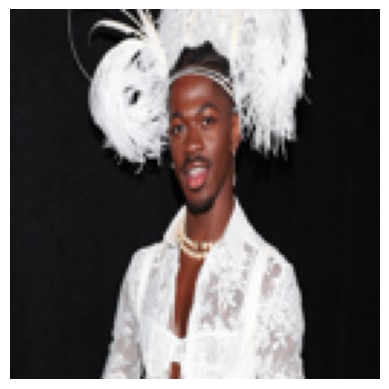

In [15]:
url = "https://static01.nyt.com/images/2024/01/18/arts/16lilnasx-notebook/16lilnasx-notebook-threeByTwoSmallAt2X.jpg?format=pjpg&quality=75&auto=webp&disable=upscale"
img = download_image(url, (128, 128))
show_image(img.permute(1, 2, 0));

In [12]:
#| hide
import nbdev

nbdev.nbdev_export()